In [1051]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# 1. Load and crop
path = "output/raw_0350.png"
img = cv2.imread(path)
h = img.shape[0]
cropped = img[:h//2, :]
# show the cropped image
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))    
plt.axis('off')
plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

Darkest area found at: (200, 135)
Darkest point RGB value: [36 36 36]
Darkest point grayscale value: 36


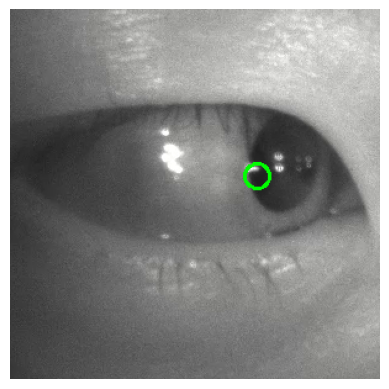

In [ ]:
# coarse positioning of eye using haar cascade
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
eyes = eye_cascade.detectMultiScale(cropped, scaleFactor=1.5, minNeighbors=3, minSize=(100, 100))
# 2. Draw rectangles around detected eyes
x, y, w, h = eyes[0] if len(eyes) > 0 else (0, 0, 0, 0)
x, y, w, h = 50,50, 300, 300  # manually set for testing
# crop image to the eye boundaries
def find_dark_patch(image):
    step = 5
    #find darkest 5x5 patch in the image 
    min_val = 255
    min_loc = (0, 0)
    h, w = image.shape[:2]
    for y in range(0, h - step, step):
        for x in range(0, w - step, step):
            patch = image[y:y + step, x:x + step]
            mean_val = np.mean(patch)
            if mean_val < min_val:
                min_val = mean_val
                min_loc = (x, y)
    return min_loc

dark_patch = find_dark_patch(cropped)
plt.scatter(dark_patch[0], dark_patch[1], color='red', s=100, label='Dark Patch')
eye_crop = cropped[y:y + h, x:x + w]
# show the cropped eye image
plt.imshow(cv2.cvtColor(eye_crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

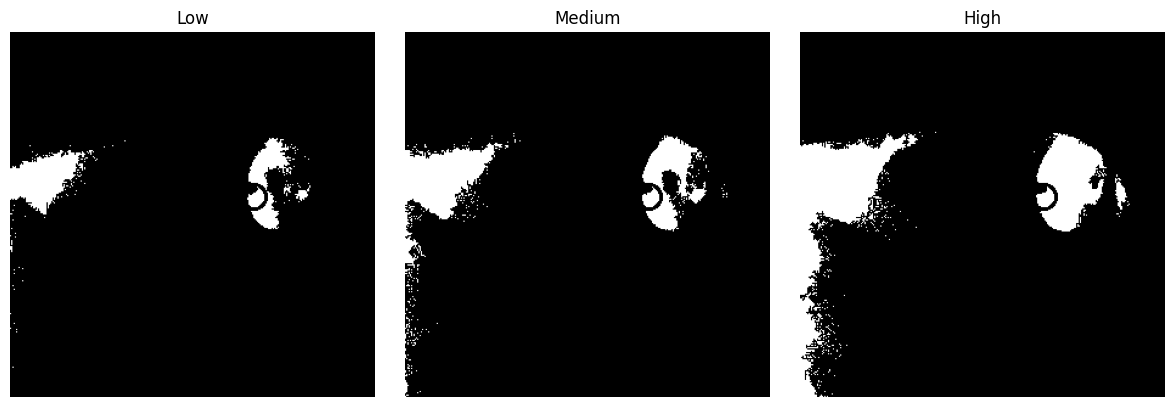

In [ ]:
eye_gray = cv2.cvtColor(eye_crop, cv2.COLOR_BGR2GRAY)

# Define three threshold values
thresholds = [40, 50, 60]  # Low, Medium, High
# thresholds = [15, 20, 25]  # Low, Medium, High
titles = ['Low', 'Medium', 'High']
images = []
hists = []
bounds = []
for t in thresholds:
    # Apply binary inverse threshold
    _, eye_thresh = cv2.threshold(eye_gray, t, 255, cv2.THRESH_BINARY_INV)

    # Fill holes using flood fill
    h, w = eye_thresh.shape
    mask = np.zeros((h + 2, w + 2), np.uint8)
    flood = eye_thresh.copy()
    cv2.floodFill(flood, mask, (0, 0), 255)
    flood_inv = cv2.bitwise_not(flood)
    eye_thresh_filled = cv2.bitwise_or(eye_thresh, flood_inv)
    
    images.append(eye_thresh_filled)
    x_hist = np.sum(eye_thresh_filled, axis=0)
    hists.append(x_hist)

# Plot the images side by side
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

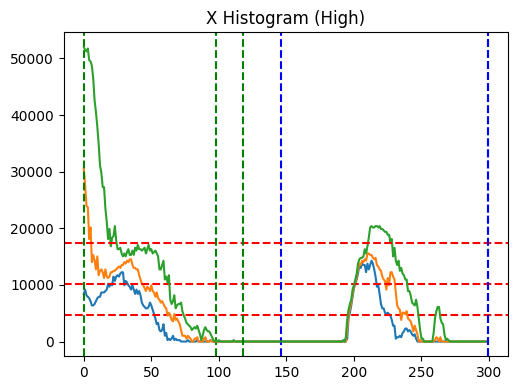

In [ ]:
def longest_nonzero_segment(arr):
    incline_thresh = 2000
    n = len(arr)
    if n < 3:
        return (None, None)
    arr = np.asarray(arr, dtype=np.int64)

    # 1) Locate first large incline
    incline = 0
    for i in range(1, n-1):
        if arr[i+1] - arr[i] > incline_thresh:
            incline = i
            break
    else:
        incline = 0

    # 2) Search for longest non-zero segment in arr[valley:]
    start = end = None
    max_len = 0
    temp_start = None

    for i in range(incline, n):
        if arr[i] != 0:
            if temp_start is None:
                temp_start = i
        else:
            if temp_start is not None:
                length = i - temp_start
                if length > max_len:
                    max_len = length
                    start, end = temp_start, i - 1
                temp_start = None

    # Handle case where array ends in a non-zero segment
    if temp_start is not None:
        length = n - temp_start
        if length > max_len:
            start, end = temp_start, n - 1

    return (start, end)



# Find the longest segment above the middle value

middles = []
# Plot the histogram
plt.figure(figsize=(15, 4))
for x_hist in hists:
    
    middle = x_hist[np.argmax(x_hist)] / 3
    middles.append(middle)
    above = np.where(x_hist > middle, x_hist, 0)
    start, end = longest_nonzero_segment(above)

    # Extend start and end based on slope
    while start > 0 and x_hist[start-1] < x_hist[start]:
        start -= 2
    while end < len(x_hist) - 1 and x_hist[end+1] < x_hist[end]:
        end += 2
    
    center = (start + end) // 2
    delta = end - center
    start -= int((center-start)*100/delta)
    end += int((end-center)*100/delta)
    # check not out of bounds
    start = max(0, start)
    end = min(len(x_hist) - 1, end)
    bounds.append((start, end))
    plt.subplot(1, 3, i + 1)
    plt.plot(x_hist)
    plt.axhline(y=middle, color='r', linestyle='--', label='Middle Threshold')
    plt.axvline(x=start, color='g', linestyle='--', label='Start')
    plt.axvline(x=end, color='b', linestyle='--', label='End')
    plt.title(f"X Histogram ({titles[i]})")
    plt.tight_layout()

plt.show()

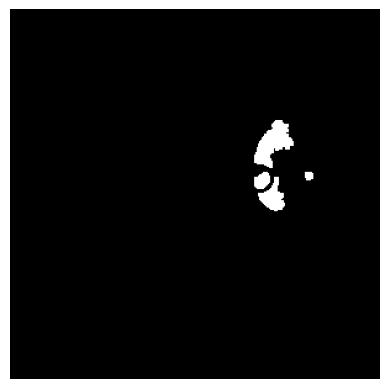

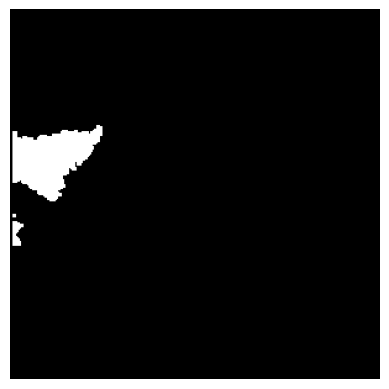

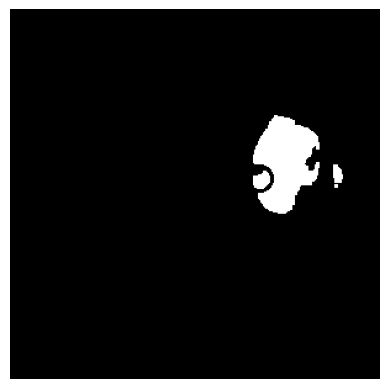

In [ ]:
# set all pixel values to 0 except for the segment between start and end
for i in range(3):
    start, end = bounds[i]
    image = images[i]
    image[:, :start] = 0
    image[:, end:] = 0
    # fill in holes
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, np.zeros((3, 3), np.uint8))
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    # show the filled thresholded eye image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()



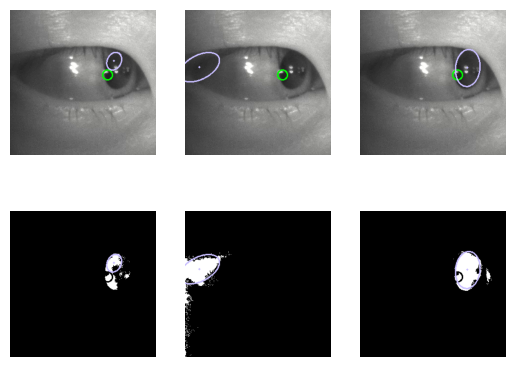

In [ ]:
ellipses = []
for i in range(3):
    image = images[i].copy()  # Binary mask (grayscale)
    output_img = eye_crop.copy()  # Original eye image for ellipse drawing

    # Find contours
    contours = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    margin = 3
    h_crop, w_crop = image.shape[:2]
    cleaned_contours = []

    for cnt in contours:
        # Filter points near the edges
        kept_points = [pt for pt in cnt if
                       margin < pt[0][0] < (w_crop - margin) and
                       margin < pt[0][1] < (h_crop - margin)]
        if len(kept_points) >= 5:
            cleaned_contours.append(np.array(kept_points).reshape(-1, 1, 2))
    ellipse_drawn = False
    contours = [cv2.convexHull(cnt) for cnt in cleaned_contours]
    if cleaned_contours:
        largest = max(cleaned_contours, key=cv2.contourArea)
        if len(largest) >= 5:
            ellipse = cv2.fitEllipse(largest)
            ellipses.append(ellipse)
            # Draw on original image
            cv2.ellipse(output_img, ellipse, (255, 190, 200), 2)
            cv2.circle(output_img, (int(ellipse[0][0]), int(ellipse[0][1])), 2, (255, 190, 200), -1)

            # Draw on binary mask (convert to color first)
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            cv2.ellipse(image_color, ellipse, (255, 190, 200), 2)
            cv2.circle(image_color, (int(ellipse[0][0]), int(ellipse[0][1])), 2, (255, 190, 200), -1)
            ellipse_drawn = True
        else:
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Top row: ellipse on original image
    plt.subplot(2, 3, i + 1)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Bottom row: ellipse on binary mask
    plt.subplot(2, 3, i + 4)
    plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
    plt.axis('off')

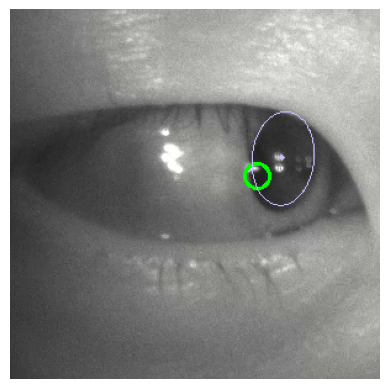

In [ ]:
# calculate percent of white pixels in the ellipse area
percents = []
for i in range(3):
    eye_thresh = images[i]
    ellipse_mask = np.zeros_like(eye_thresh)
    
    if ellipses[i]:
        ellipse = ellipses[i]
        center = (int(ellipse[0][0]), int(ellipse[0][1]))
        axes = (int(ellipse[1][0] / 2), int(ellipse[1][1] / 2))
        angle = int(ellipse[2])
        
        # Draw the ellipse on the mask
        cv2.ellipse(ellipse_mask, center, axes, angle, 0, 360, 255, -1)
    # Calculate the percentage of white pixels in the ellipse area
    white_pixels = cv2.countNonZero(cv2.bitwise_and(eye_thresh, ellipse_mask))
    total_pixels = cv2.countNonZero(ellipse_mask)
    percentage = (white_pixels / total_pixels) * 100 if total_pixels > 0 else 0
    if total_pixels < 100:
        percentage = 0
    percents.append(percentage)

best_index = np.argmax(percents)
# Show the best ellipse
best_ellipse = ellipses[best_index]
# plot elipse and center on the cropped eye image
output_img = eye_crop.copy()
cv2.ellipse(output_img, best_ellipse, (255, 190, 200), 1)
cv2.circle(output_img, (int(best_ellipse[0][0]), int(best_ellipse[0][1])), 2, (255, 190, 200), -1)
plt.axis('off')
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    